# Rotated PV-mSME: extra studies

In [1]:
import numpy
from matplotlib import pyplot

# Plot visible cross-section against hour of rotation.

The non-rotating PV-mSME is at 0 (and 24).

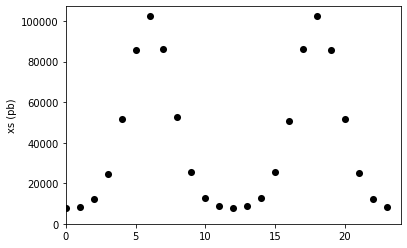

In [2]:
def plot_xs():
    hour, xs_pre, *_ = numpy.loadtxt(
        "results/rot_xs.csv", skiprows=1, delimiter=",",
    ).T
    _, nsamples, ngenerated = numpy.loadtxt(
        "results/rot_acceptance_truth.csv", skiprows=1, delimiter=",",
    ).T
    acc = nsamples / ngenerated
    xs = xs_pre * acc
    
    pyplot.scatter(hour, xs, color="k", marker=".", lw=0, s=200)
    pyplot.xlim(0, 24)
    pyplot.ylabel("xs (pb)")
    pyplot.ylim(0)
    pyplot.show()
    
    
plot_xs()

# Inspect the hour-dependence of results in a fitted model.

This loosely follows content from `parity_tests/jet_net_test_rot.py

In [3]:
import os
import sys
import glob

import h5py
import jax

from parity_tests import jet_lib, jet_net_lib
from parity_tests.jet_lib import load_rot, load_rot_xs
from parity_tests.jet_net_lib import make_net, parity_flip_jax, prescale, zeta_20_20_10

In [4]:
# UPDATE FOR YOUR LOCAL SYSTEM
DATAPATH = "/home/tombs/Downloads/paper-hunting-vampires-zenodo/data/"

In [5]:
def evaluate_net(model_path, data):
    params, meta = jet_net_lib.fit_load(model_path)

    net = make_net(zeta_20_20_10)

    pre_loc, pre_scale = meta["prescale"].values()
    pre_loc = jax.numpy.array(pre_loc, dtype=numpy.float32)
    pre_scale = jax.numpy.array(pre_scale, dtype=numpy.float32)

    @jax.jit
    def net_phi(params, x):
        x = prescale(x, pre_loc, pre_scale)
        zeta = net.net
        phi_1 = zeta.apply(params, x) - zeta.apply(params, parity_flip_jax(x))
        return phi_1.ravel()

    return numpy.array(net_phi(params, data))

In [6]:
def load_data_and_phi():
    data_path = os.path.join(DATAPATH, "truth-jet-rot")
    model_path = "results/models/rot/"
    ntest = 6_000_000
    
    xs = load_rot_xs()
    probs = xs / xs.sum()

    rng = numpy.random.Generator(numpy.random.Philox(31415))

    path = os.path.join(data_path, "private_test")
    nper = rng.multinomial(ntest, probs)
    data = load_rot(path, nper=nper)
    
    phi = evaluate_net(model_path, data)
    
    return data, phi


DATA, PHI = load_data_and_phi()

7.598517407973592e-06


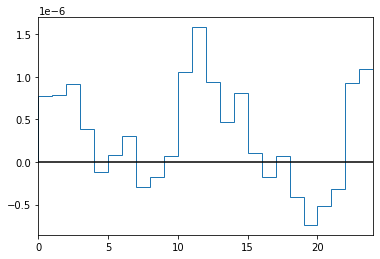

In [7]:
def plot():
    sin, cos = DATA[:, -2:].T
    theta = numpy.arctan2(sin, cos) % (2 * numpy.pi)
    # we only have small rounding errors from float32 operations
    hour = numpy.round(theta / (2 * numpy.pi) * 24)
        
    quality_i = (-numpy.logaddexp(0, -PHI) - numpy.log(0.5)) / len(PHI)
    
    print(quality_i.sum())
    
    pyplot.hist(
        hour,
        bins=24,
        range=(0, 24),
        weights=quality_i,
        histtype="step",
    )
    pyplot.axhline(0, color="k")
    pyplot.xlim(0, 24)
    pyplot.show()

plot()